In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/full-satellite-data/satellite_constellation_federated_learning_dataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/full-satellite-data/satellite_constellation_federated_learning_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Satellite_ID                  50000 non-null  int64  
 1   Latency_ms                    50000 non-null  float64
 2   Bandwidth_Mbps                50000 non-null  float64
 3   Energy_Consumption_J          50000 non-null  float64
 4   Num_Nodes_Constellation       50000 non-null  int64  
 5   Intermittent_Connectivity     50000 non-null  int64  
 6   Dynamic_Topology_Change       50000 non-null  int64  
 7   Training_Time_sec             50000 non-null  float64
 8   Training_Accuracy_%           50000 non-null  float64
 9   Training_Rounds               50000 non-null  int64  
 10  Satellite_Altitude_km         50000 non-null  float64
 11  Satellite_Type                50000 non-null  object 
 12  Signal_Strength_dB            50000 non-null  float64
 13  D

In [3]:
N = len(df)  # number of rows
start_time = pd.Timestamp('2025-01-01 00:00:00')

df['timestamp'] = pd.date_range(start=start_time, periods=N, freq='S')  # freq='S' → 1 second

/tmp/ipykernel_19/563387202.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = pd.date_range(start=start_time, periods=N, freq='S')  # freq='S' → 1 second


In [4]:
# Save the dataset with the timestamp column
df.to_csv("satellite_data_with_timestamp.csv")

In [5]:
df2 = pd.read_csv("satellite_data_with_timestamp.csv")
df2.head(5)

,Unnamed: 0,Satellite_ID,Latency_ms,Bandwidth_Mbps,Energy_Consumption_J,Num_Nodes_Constellation,Intermittent_Connectivity,Dynamic_Topology_Change,Training_Time_sec,Training_Accuracy_%,...,Satellite_Type,Signal_Strength_dB,Data_Size_GB,Satellite_Health,Satellite_Region,Model_Convergence_Rate_%,Communication_Success_Rate_%,Data_Sharing_Rate_Mbps,CPU_Usage_%,timestamp
0,0,103,98.908385,23.401082,96.510298,88,1,1,21907.136832,78.068901,...,Science,87.688644,42.368660,88.297596,Polar Orbit,94.723935,97.722509,84.825917,69.768840,2025-01-01 00:00:00
1,1,436,119.009508,73.711399,94.234733,55,0,1,10484.165803,90.259651,...,Earth Observation,87.519931,14.549679,56.231099,Low Earth Orbit,91.433812,91.209619,62.276699,20.235987,2025-01-01 00:00:01
2,2,861,242.764729,-8.331131,57.272108,84,1,0,26530.982961,90.734786,...,Earth Observation,75.173693,45.780670,66.960278,Polar Orbit,94.418559,94.531356,62.750616,86.426333,2025-01-01 00:00:02
3,3,271,240.270491,16.935211,56.706258,7,0,0,4719.987965,82.725070,...,Communication,59.851490,8.350032,98.097768,Geostationary,93.059230,94.356661,56.112938,91.027411,2025-01-01 00:00:03
4,4,107,155.545793,24.625514,94.071044,82,0,1,14002.936759,81.862861,...,Science,63.195948,40.512776,61.276687,Polar Orbit,94.084595,86.408111,84.128463,89.819895,2025-01-01 00:00:04


In [6]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import matplotlib.pyplot as plt

In [7]:
#Set Parameter values
SEQ_LEN = 60            # window length
STEP = 10               # sliding step
BATCH_SIZE = 64
HIDDEN_SIZE = 64
LATENT_SIZE = 16
NUM_LAYERS = 2
LR = 1e-3
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#Load and Pre-process telemetry data
def load_telemetry(path: str, timestamp_col='timestamp', drop_cols: List[str]=None) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=[timestamp_col])
    df = df.sort_values(timestamp_col)
    
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    # Corrected logic to ensure timestamp column is not dropped
    if timestamp_col in df.columns and timestamp_col not in numeric_cols:
        numeric_cols.append(timestamp_col)
    
    df = df[numeric_cols]
    df = df.set_index(timestamp_col)
    
    return df

In [9]:
def impute_and_resample(df: pd.DataFrame, freq='1S', method='linear') -> pd.DataFrame:
    # Resample to fixed frequency and fill missing via interpolation
    df = df.resample(freq).mean()
    df = df.interpolate(method=method).ffill().bfill()
    return df

In [10]:

def create_windows(data: np.ndarray, seq_len: int, step: int) -> np.ndarray:
    n, d = data.shape
    windows = []
    for start in range(0, n - seq_len + 1, step):
        windows.append(data[start:start+seq_len])
    return np.stack(windows)  # shape (num_windows, seq_len, d)

In [11]:
#Sequence Dataset
class SequenceDataset(Dataset):
    def __init__(self, windows: np.ndarray):
        self.windows = windows.astype(np.float32)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx]

In [12]:
#Pytorch LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, latent_size=16, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.enc_fc = nn.Linear(hidden_size, latent_size)

        self.dec_fc = nn.Linear(latent_size, hidden_size)
        
        # The decoder now takes a single input of hidden_size to generate the sequence
        self.decoder_rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x: (B, T, D) -> Batch, Time, Dimensions
        B, T, D = x.size()
        
        # Encoder
        # The encoder takes the full sequence and produces a final hidden state.
        # h_n and c_n are (num_layers, B, hidden_size)
        _, (h_n, c_n) = self.encoder(x)
        
        # Latent space projection from the last layer's hidden state
        # This will be (B, hidden_size).
        latent_input = h_n[-1, :, :]
        latent = self.enc_fc(latent_input)  # (B, latent_size)

        # Decoder
        # The decoder takes the latent representation and projects it back to hidden_size.
        # This will serve as the input for each timestep of the decoder.
        decoder_input_tensor = self.dec_fc(latent).unsqueeze(1).repeat(1, T, 1)

        # The decoder_rnn's input is now (B, T, hidden_size), and it produces an output
        # of the same shape.
        decoder_output, _ = self.decoder_rnn(decoder_input_tensor)
        
        # The final reconstruction is generated by a linear layer that projects
        # from hidden_size to the original input_size (D).
        recon = self.out(decoder_output)  # recon: (B, T, D)

        return recon

In [13]:
#Training and Validation
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device=DEVICE):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            opt.step()
            train_loss += loss.item() * batch.size(0)
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon = model(batch)
                loss = criterion(recon, batch)
                val_loss += loss.item() * batch.size(0)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_lstm_autoencoder.pth")

        print(f"Epoch {epoch}/{epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
    # load best
    model.load_state_dict(torch.load("best_lstm_autoencoder.pth"))
    return model

In [14]:
#Scoring and Thresholding
def compute_reconstruction_errors(model, loader, device=DEVICE) -> np.ndarray:
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon = model(batch)
            # per-window MSE
            mse = ((recon - batch) ** 2).mean(dim=(1,2))  # (B,)
            errors.append(mse.cpu().numpy())
    return np.concatenate(errors)

def choose_threshold(errors_normal: np.ndarray, method='percentile', p=99.5) -> float:
    if method == 'percentile':
        return np.percentile(errors_normal, p)
    else:
        # fallback: mean + k*std
        return errors_normal.mean() + 3 * errors_normal.std()

/tmp/ipykernel_19/762785844.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample(freq).mean()


Epoch 1/30 train_loss=0.976361 val_loss=1.011032
Epoch 2/30 train_loss=0.948969 val_loss=0.964954
Epoch 3/30 train_loss=0.947976 val_loss=0.966718
Epoch 4/30 train_loss=0.947764 val_loss=0.966875
Epoch 5/30 train_loss=0.947631 val_loss=0.964204
Epoch 6/30 train_loss=0.947548 val_loss=0.963166
Epoch 7/30 train_loss=0.947496 val_loss=0.963734
Epoch 8/30 train_loss=0.947412 val_loss=0.962303
Epoch 9/30 train_loss=0.947395 val_loss=0.963912
Epoch 10/30 train_loss=0.947401 val_loss=0.962441
Epoch 11/30 train_loss=0.947341 val_loss=0.963650
Epoch 12/30 train_loss=0.947307 val_loss=0.962173
Epoch 13/30 train_loss=0.947274 val_loss=0.961161
Epoch 14/30 train_loss=0.947160 val_loss=0.958863
Epoch 15/30 train_loss=0.946766 val_loss=0.957393
Epoch 16/30 train_loss=0.946290 val_loss=0.954504
Epoch 17/30 train_loss=0.945968 val_loss=0.954114
Epoch 18/30 train_loss=0.945638 val_loss=0.952202
Epoch 19/30 train_loss=0.945291 val_loss=0.949798
Epoch 20/30 train_loss=0.945088 val_loss=0.950532
Epoch 21/

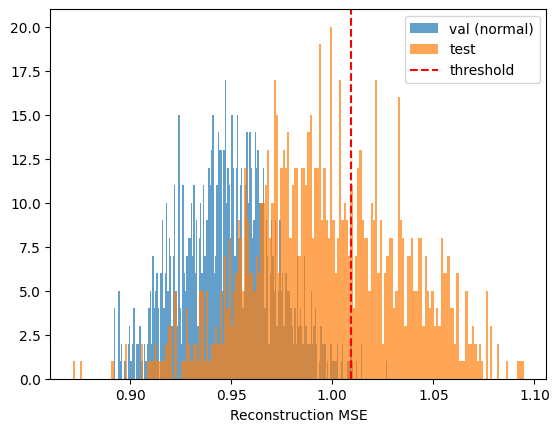

In [15]:
if __name__ == "__main__":
    # 1. load
    # Ensure the path and column names are correct
    df = load_telemetry("satellite_data_with_timestamp.csv", timestamp_col='timestamp', drop_cols=['sat_id'])
    
    df = impute_and_resample(df, freq='1S')
    
    # Correctly define features AFTER resampling and dropping non-numeric columns
    features = df.columns.tolist()

    # 2. split: assume we have a period of normal operation for training
    n = len(df)
    train_df = df.iloc[: int(0.6 * n)]
    val_df = df.iloc[int(0.6 * n): int(0.8 * n)]
    test_df = df.iloc[int(0.8 * n):]

    # 3. scale based on train only
    scaler = StandardScaler()
    scaler.fit(train_df.values)
    train_scaled = scaler.transform(train_df.values)
    val_scaled = scaler.transform(val_df.values)
    test_scaled = scaler.transform(test_df.values)
    
    # 4. window
    train_w = create_windows(train_scaled, SEQ_LEN, STEP)
    val_w   = create_windows(val_scaled, SEQ_LEN, STEP)
    test_w  = create_windows(test_scaled, SEQ_LEN, STEP)

    train_loader = DataLoader(SequenceDataset(train_w), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(SequenceDataset(val_w), batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(SequenceDataset(test_w), batch_size=BATCH_SIZE, shuffle=False)

    # 5. build model
    model = LSTMAutoencoder(input_size=len(features), hidden_size=HIDDEN_SIZE, latent_size=LATENT_SIZE, num_layers=NUM_LAYERS)
    model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

    # 6. compute reconstruction error on validation normal windows to set threshold
    val_errors = compute_reconstruction_errors(model, val_loader)
    threshold = choose_threshold(val_errors, method='percentile', p=99.5)
    print("Chosen threshold:", threshold)

    # 7. score test set
    test_errors = compute_reconstruction_errors(model, test_loader)

    # OPTIONAL: if you have test labels for each window (0 normal, 1 anomaly), evaluate
    # labels_per_window = ... (align labels to windows)
    # evaluate_scores(test_errors, labels_per_window)

    # 8. plot histogram of errors
    plt.figure()
    plt.hist(val_errors, bins=200, alpha=0.7, label='val (normal)')
    plt.hist(test_errors, bins=200, alpha=0.7, label='test')
    plt.axvline(threshold, color='r', linestyle='--', label='threshold')
    plt.legend()
    plt.xlabel("Reconstruction MSE")
    plt.show()

    # 9. for deployment: compute score per incoming sliding window and raise alert if score > threshold